# Part1:

In [1]:
from sklearn.model_selection import ParameterGrid
from models import SARSA,QLearning,ExpectedSARSA
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_experiment(agent,description):
    RUNS = 10
    SEGMENTS = 100
    TRAIN_EPISODES = 10
    TEST_EPISODES = 1
    train_scores = []
    test_scores = []
    pbar = tqdm(range(RUNS))
    for run in pbar:
        agent.reset()
        for segment in range(SEGMENTS):
            pbar.set_description(f"SEGMENT {segment:2d} | "+description)
            train_scores.append(agent.run(n_episodes=TRAIN_EPISODES, max_steps=200,verbose=0))
            test_scores.append(agent.run(n_episodes=TEST_EPISODES,render=False, max_steps=200,mode="test",verbose=0))
        
    train_scores = np.array(train_scores).reshape(RUNS,SEGMENTS,TRAIN_EPISODES)
    test_scores = np.array(test_scores).reshape(RUNS,SEGMENTS,TEST_EPISODES)
    return train_scores,test_scores


In [3]:
def run_grid_search(algorithm,grid):
    parameters = ParameterGrid(grid)
    history = []
    results_df = pd.DataFrame(columns=["init_temperature","alpha","avg_reward_train","avg_reward_test"])
    for param in parameters:
        agent_sarsa = algorithm('Taxi-v2',
                    exploration="softmax",
                    init_temperature=param["init_temperature"],
                    decay=1, 
                    alpha=param["alpha"], 
                    gamma=1
        )
        description = "training with params:"+" - ".join(map(lambda x:f"{x[0]}={x[1]:1.2f}",param.items()))
        train_scores,test_scores = run_experiment(agent_sarsa,description = description)
        history.append((train_scores,test_scores))

        avg_reward_test  = test_scores[:,-1,:].mean()
        avg_reward_train = train_scores[:,-1,-1].mean()
        results_df = results_df.append(pd.DataFrame([{'alpha': param["alpha"], 
                                                      'init_temperature': param["init_temperature"],
                                                      'avg_reward_train':avg_reward_train,
                                                      'avg_reward_test':avg_reward_test}]),sort=True,ignore_index=True)
    
    return history, results_df


In [4]:
def plot_parameter_influence(grid_results):
    plt.rcParams['figure.figsize'] = 15, 5
    
    # Plot Testing results
    ax = plt.subplot(1,2,1)
    for init_temperature in results_df["init_temperature"].unique():
        grid_results.loc[grid_results["init_temperature"]==init_temperature].plot(x="alpha",y="avg_reward_test",ax=ax,marker="o", linestyle='dashed',label=f"Temperature = {init_temperature}")
    for i,row in grid_results.iterrows():
        ax.annotate(i, (row["alpha"], row["avg_reward_test"]),xytext=(5,10),textcoords='offset points')
        
    plt.ylabel("Final Reward")
    plt.xlabel("Learning Rate")
    plt.title("Parameters influence on the final reward - Testing")
    
    # Plot Training results
    ax = plt.subplot(1,2,2)
    for init_temperature in results_df["init_temperature"].unique():
        grid_results.loc[grid_results["init_temperature"]==init_temperature].plot(x="alpha",y="avg_reward_train",ax=ax,marker="o", linestyle='dashed',label=f"Temperature = {init_temperature}")
    
    for i,row in grid_results.iterrows():
        ax.annotate(i, (row["alpha"], row["avg_reward_train"]),xytext=(5,10),textcoords='offset points')
    plt.ylabel("Final Reward")
    plt.xlabel("Learning Rate")
    plt.title("Parameters influence on the final reward - Training")

    plt.show()
    
def plot_learning_curves(history,best_idx):
    plt.rcParams['figure.figsize'] = 15, 10
    train_arr,test_arr = history[best_idx]
    
    # Plot Learning curves
    plt.subplot(2,2,1)
    plt.plot(train_arr.mean((0,2)).reshape(-1,1))
    plt.title("Learning curve - mean - training")
    plt.xlabel("Training episodes")
    plt.ylabel("Averaged Reward")
    
    plt.subplot(2,2,2)
    plt.plot(train_arr.std((0,2)).reshape(-1,1))
    plt.title("Learning curve - std - training")
    plt.ylabel("Standard Deviation of Reward")
    plt.xlabel("Training episodes")
    
    plt.subplot(2,2,3)
    plt.plot(test_arr.mean(0))
    plt.title("Learning curve - mean - testing")
    plt.ylabel("Averaged Reward")
    plt.xlabel("Testing episodes")
    
    plt.subplot(2,2,4)
    plt.plot(test_arr.std(0))
    plt.title("Learning curve - std - testing")
    plt.ylabel("Standard Deviation of Reward")
    plt.xlabel("Testing episodes")

    plt.show()


In [5]:
grid = {
    "init_temperature":[0.1,.3,1],
    "alpha":[0.3,0.7,0.9]
}


## Sarsa

In [10]:
history, results_df = run_grid_search(SARSA,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT 99 | training with params:alpha=0.30 - init_temperature=0.10: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]
SEGMENT 99 | training with params:alpha=0.30 - init_temperature=0.30: 100%|██████████| 10/10 [01:15<00:00,  7.51s/it]
SEGMENT 99 | training with params:alpha=0.30 - init_temperature=1.00: 100%|██████████| 10/10 [01:35<00:00,  9.55s/it]
SEGMENT 99 | training with params:alpha=0.70 - init_temperature=0.10: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it]
SEGMENT 99 | training with params:alpha=0.70 - init_temperature=0.30: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]
SEGMENT 99 | training with params:alpha=0.70 - init_temperature=1.00: 100%|██████████| 10/10 [00:57<00:00,  5.80s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0

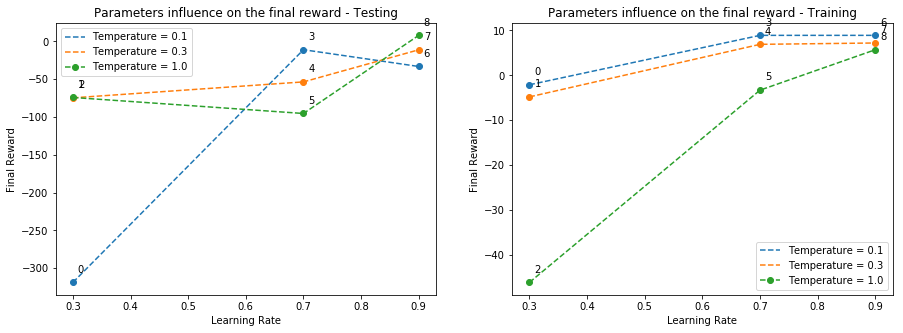

In [11]:
plot_parameter_influence(results_df)

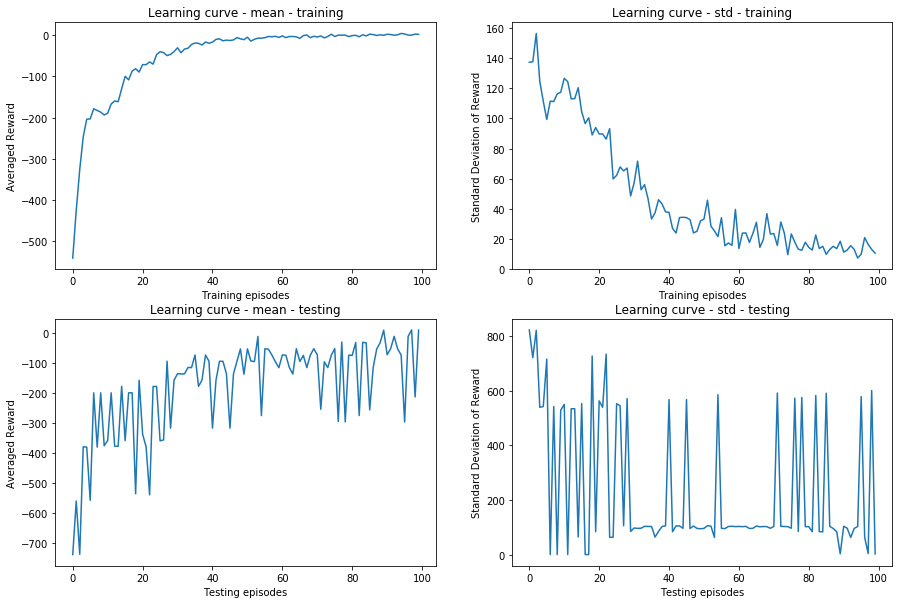

In [13]:
plot_learning_curves(history,best_idx=8)

## QLearning

In [8]:
history, results_df = run_grid_search(QLearning,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT 99 | training with params:alpha=0.3 - init_temperature=0.1: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it]
SEGMENT 99 | training with params:alpha=0.3 - init_temperature=0.3: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it]
SEGMENT 99 | training with params:alpha=0.3 - init_temperature=1: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it]
SEGMENT 99 | training with params:alpha=0.7 - init_temperature=0.1: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]
SEGMENT 99 | training with params:alpha=0.7 - init_temperature=0.3: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]
SEGMENT 99 | training with params:alpha=0.7 - init_temperature=1: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]
SEGMENT 99 | training with params:alpha=0.9 - init_temperature=0.1: 100%|████████

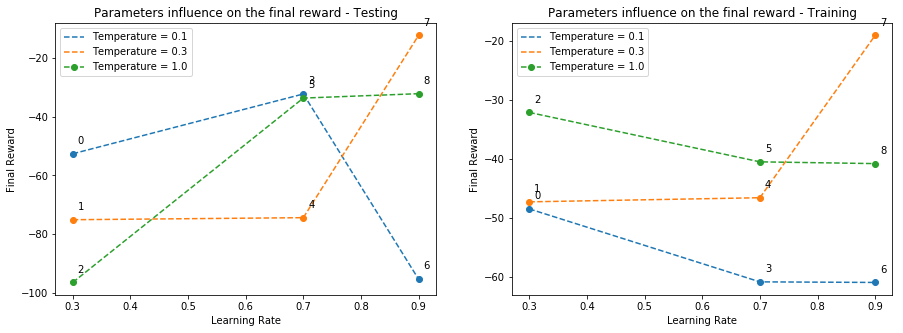

In [17]:
plot_parameter_influence(results_df)

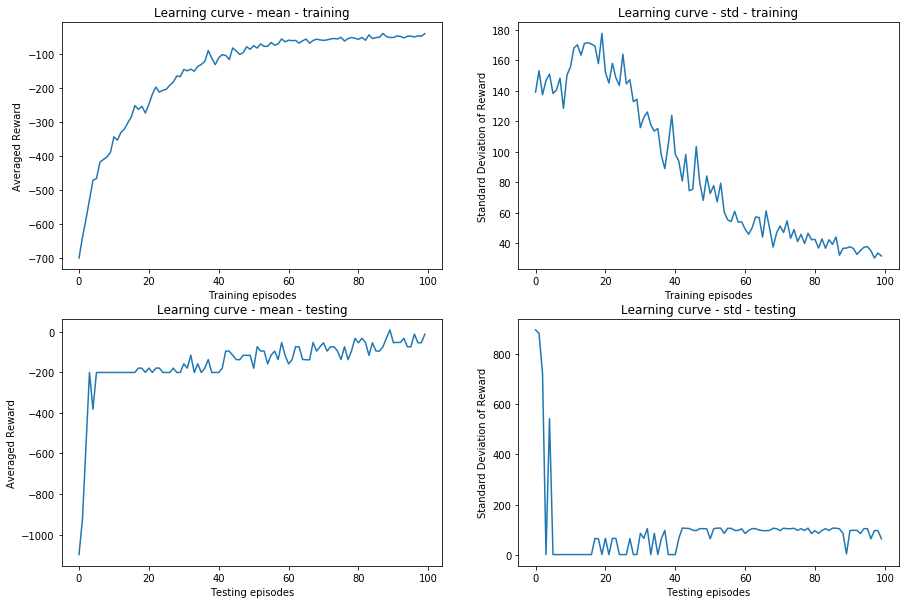

In [18]:
plot_learning_curves(history,best_idx=7)

## ExpectedSARSA

In [6]:
history, results_df = run_grid_search(ExpectedSARSA,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT 99 | training with params:alpha=0.30 - init_temperature=0.10: 100%|██████████| 10/10 [01:46<00:00, 10.67s/it]
SEGMENT 99 | training with params:alpha=0.30 - init_temperature=0.30: 100%|██████████| 10/10 [01:43<00:00, 10.34s/it]
SEGMENT 99 | training with params:alpha=0.30 - init_temperature=1.00: 100%|██████████| 10/10 [01:45<00:00, 10.51s/it]
SEGMENT 99 | training with params:alpha=0.70 - init_temperature=0.10: 100%|██████████| 10/10 [01:47<00:00, 10.75s/it]
SEGMENT 99 | training with params:alpha=0.70 - init_temperature=0.30: 100%|██████████| 10/10 [01:50<00:00, 11.03s/it]
SEGMENT 99 | training with params:alpha=0.70 - init_temperature=1.00: 100%|██████████| 10/10 [01:45<00:00, 10.52s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0

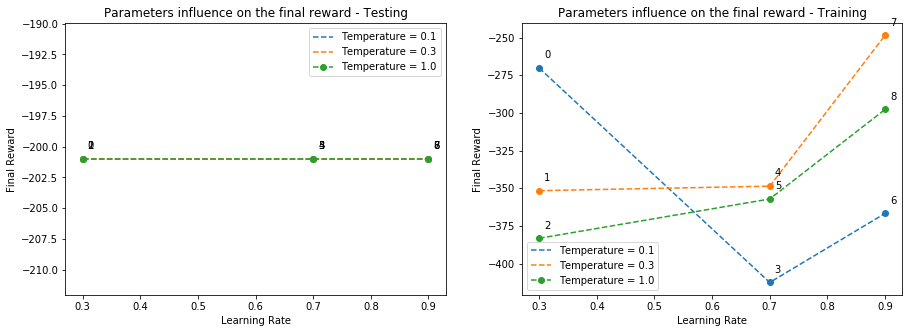

In [7]:
plot_parameter_influence(results_df)

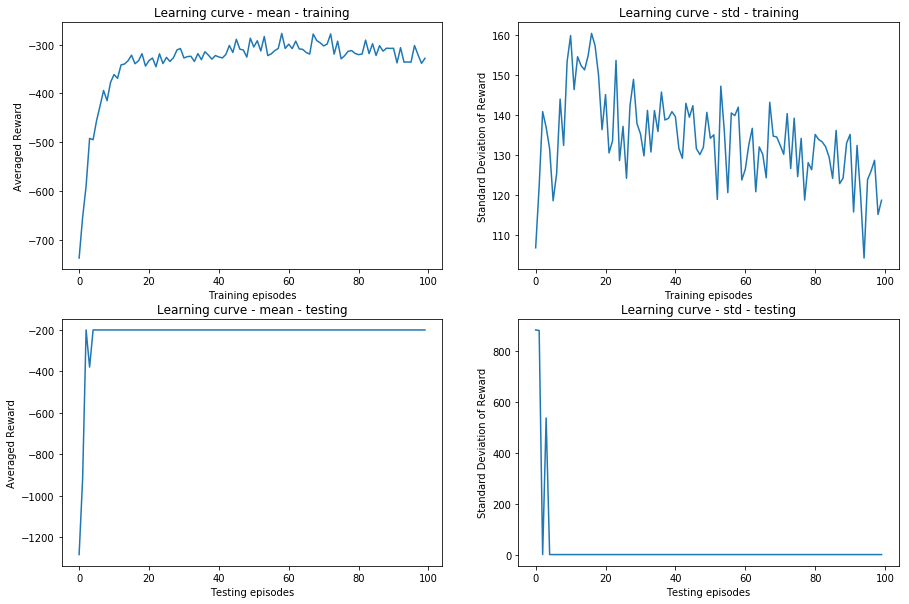

In [8]:
plot_learning_curves(history,best_idx=7)